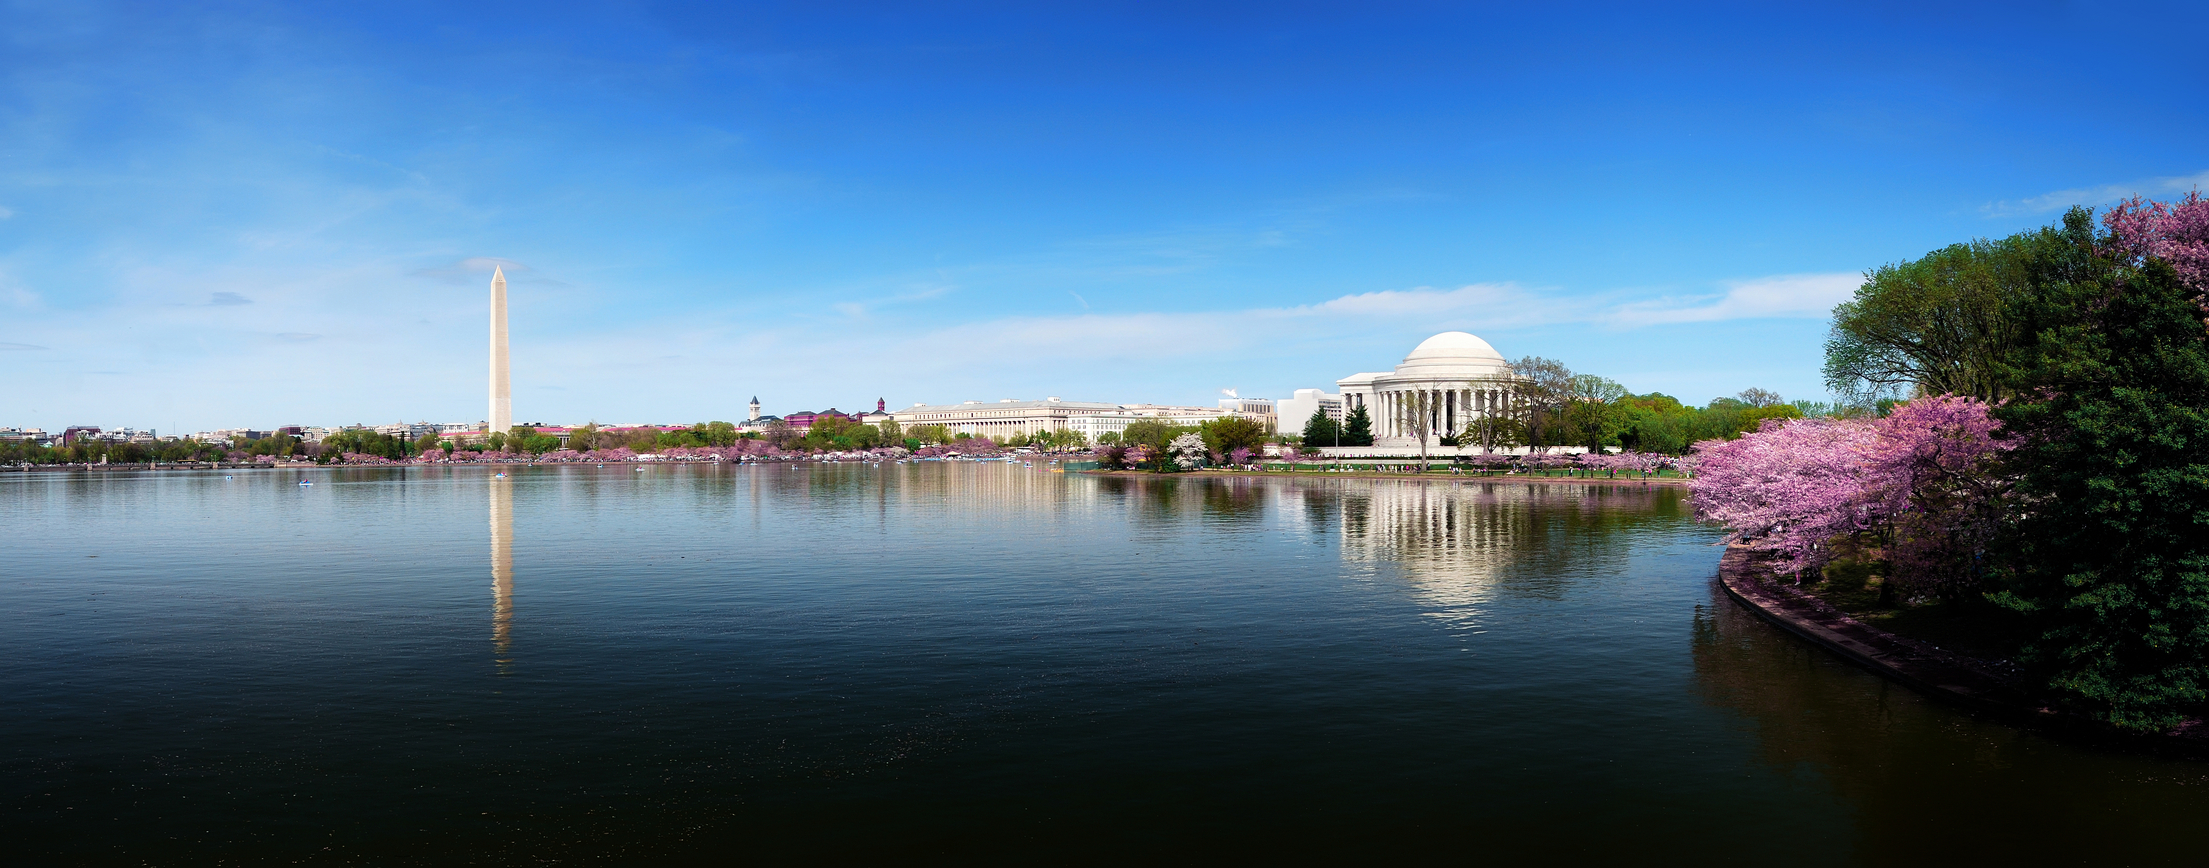

# Coursera Capstion - Washington DC Appartments

Capstone Project for the IBM Data Science Professional Certificate.

## 1.0 Introduction:

Washington DC is known for being one of the most culturally diverse cities in the United States. With so many individuals coming from all around the globe for work purposes, many communities have found homes in the Disctrict over the years. A fantastic side effect of this cultural diversity is that you can find cuisine of almost any variety reporesented here.

The goal of this project is to identify appartments around DC that have the bests food options available and what similar appartments can be grouped together.

### 1.1 Problem

If I am an individual moving to DC and I want to know how to which appartment building will give me the best dining options how would I do it? 

To solve this problem we will need several things:

- Data of appartments in the DC area
- Data of different food venues around these appartments
- A way to analyze said data
    
### 1.2 Data 

The data that will be used to address the above problem will come from 2 different sources:

1. The [Basic Business Licenses](https://opendata.dc.gov/datasets/basic-business-licenses/data)  data from the local DC government. The City of DC has large datasets that are available to the public. These data cover a variety of interesting topics and in our case we will use a set that contains information on businesses liscensed in the city. An appartment is a business and so we will be able to filter or just the DC area appartment buildings
2. Venue data form [Foursquare API](https://developer.foursquare.com/docs). We will find the top venues for each appartment by leveraging the Foursquare API. We can set parameters to gather only data on food venues to tailor our results to the problem.

## 2.0 Methodology:

In this section we will tackle all data import and processing as well as all technical analysis.

### 2.1 Import Libraries

In [3]:
import pandas as pd
import numpy as np
import json 

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

### 2.2 Data Load

#### Business Liscense Data

First the business liscense data will be loaded and processed.

In [4]:
# Read csv
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_5157a5e60f24492a85f2cb22333207d6 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='b80NN4K581jPKw5rdr_gBlDUfQo1rGccLbpp84JYMtwz',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_5157a5e60f24492a85f2cb22333207d6.get_object(Bucket='machinelearninginpython-donotdelete-pr-h1bvrrrw6njkjz',Key='Basic_Business_Licenses.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_data_0 = pd.read_csv(body)
df_data_0.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


BILLING_ADDRESS             BILLING_ADDRESS_CITY_STATE_ZIP AGENT_ENTITY  \
0             NaN   14709 CHESTERFIELD R ROCKVILLE MD 20853           NaN   
1             NaN       P.O. BOX 71061 CHEVY CHASE MD 20813                 
2             NaN   3939 BENNING RD NE  WASHINGTON DC 20019           NaN   
3             NaN  3939  BENNING RD NE  WASHINGTON DC 20019           NaN   
4   Suit/Unit# #2  1628 MONTELLO AVE NE WASHINGTON DC 20002           NaN   

  AGENT_FIRST_NAME AGENT_LAST_NAME AGENT_MIDDLE_NAME AGENT_PHONE  \
0            FRANK         BACELLI               NaN  2026371000   
1                                                NaN         NaN   
2          GEORGE          KEYS JR                 R  2024388300   
3           GEORGE         KEYS JR                 R  2024388300   
4              NaN             NaN               NaN         NaN   

                 SITE_ADDRESS   BBL_CITY_STATE_ZIP  \
0            2221 40TH PL NW   WASHINGTON DC 20007   
1  1805 1809 MARYLAND AVE NE   WASHINGTON DC 20015   
2        3811 3817 JAY ST NE   WASHINGTON DC 20019   
3        3763 3773 JAY ST NE   WASHINGTON DC 20019   
4           1227 QUEEN ST NE   WASHINGTON DC 20002   

                            BILLING_NAME  ...  ZIPCODE MARADDRESSREPOSITORYID  \
0                                    NaN  ...      NaN               270824.0   
1  PM ASSOCIATES, A MARYLAND PARTNERSHIP  ...      NaN                    NaN   
2           MAYFAIR MANISIONS CONDO LLC   ...      NaN                    NaN   
3            MAYFAIR MANSIONS CONDO LLC   ...      NaN                    NaN   
4                                    NaN  ...      NaN                70606.0   

  WARD  ANC   SMD DISTRICT    PSA NEIGHBORHOODCLUSTER  \
0  3.0   3B  3B03   SECOND  204.0          Cluster 14   
1  NaN  NaN   NaN      NaN    NaN                 NaN   
2  NaN  NaN   NaN      NaN    NaN                 NaN   
3  NaN  NaN   NaN      NaN    NaN                 NaN   
4  5.0   5D  5D07    FIFTH  506.0          Cluster 23   

  BUSINESSIMPROVEMENTDISTRICT MAINSTREET  
0                         NaN        NaN  
1                         NaN        NaN  
2                         NaN        NaN  
3                         NaN        NaN  
4                         NaN        NaN  

[5 rows x 44 columns]

In [5]:
# Keep only the column we need
df_Conden = df_data_0[['BILLING_ADDRESS_CITY_STATE_ZIP','AGENT_ENTITY','LICENSESTATUS','LATITUDE','LONGITUDE']]

# Filter out any businesses that no longer have an active license
df_Conden = df_Conden.loc[df_Conden['LICENSESTATUS'] == 'Active']

# Drop NaN values for business entities with no names
df_Conden = df_Conden.dropna(subset=['AGENT_ENTITY'])
df_Conden = df_Conden.dropna(subset=['LATITUDE'])
df_Conden = df_Conden.dropna(subset=['LONGITUDE'])
df_Conden = df_Conden.dropna(subset=['BILLING_ADDRESS_CITY_STATE_ZIP'])
df_Conden = df_Conden.rename(columns={"BILLING_ADDRESS_CITY_STATE_ZIP": "Apartment"})

# Remove duplicate Apartments
df_Conden.drop_duplicates(subset ="Apartment", 
                     keep = False, inplace = True) 

df_Conden.head()

Apartment                  AGENT_ENTITY  \
2742   3333 14th STREET NW WASHINGTON DC 20010    CORPORATION SERVICE COMPANY   
2747    4827 RUGBY AVENUE, S BETHESDA MD 20814   H & G REGISTERED AGENTS INC.   
2766               PO BOX 4130 OAKTON VA 22124          CT CORPORATION SYSTEM   
2769         P O BOX 11597 WASHINGTON DC 20008    WASHINGTON REGISTRY LIMITED   
2777  6600 SANY SPRING RD  WASHINGTON DC 20012                       LPRA INC   

     LICENSESTATUS   LATITUDE  LONGITUDE  
2742        Active  38.860041 -76.985822  
2747        Active  38.932119 -77.073299  
2766        Active  38.920856 -77.074432  
2769        Active  38.905457 -77.028630  
2777        Active  38.910171 -77.019603

#### Foursquare Data

We can now bring in the various top food venues for each appartment

In [6]:
# First get the Lat and Long for DC
address = 'Washington DC, District of Columbia'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of DC are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of DC are 38.8948932, -77.0365529.


In [7]:
# Set up Foursquare API info
CLIENT_ID = 'IRVTNUAVYESBUBBNTN4L0IHM4001U24IPMKCQLO20IJOW0DM'
CLIENT_SECRET = 'WULMHN1ZYOII1OZHR1UARQRWHIWZXU5IEBVIYF0G1HM5XIUC' 
VERSION = '20180605' # Foursquare API version
categoryId = '4d4b7105d754a06374d81259'

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# Define a function to pull top the venues for each apartment
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name, lat, lng)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Apartment', 
                  'Apartment Latitude', 
                  'Apartment Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    return(nearby_venues)

In [8]:
# Use the function to pull the venue data
DC_venues = getNearbyVenues(names=df_Conden['Apartment'],
                                   latitudes=df_Conden['LATITUDE'],
                                   longitudes=df_Conden['LONGITUDE']
                                  )

In [9]:
# Clean data to only include food venues
DC_venues = DC_venues[DC_venues["Venue Category"].str.contains("Restaurant|Food|Cafe|Place", na=False)]
DC_venues.head()

Apartment  Apartment Latitude  \
5   4827 RUGBY AVENUE, S BETHESDA MD 20814            38.932119   
6   4827 RUGBY AVENUE, S BETHESDA MD 20814            38.932119   
10  4827 RUGBY AVENUE, S BETHESDA MD 20814            38.932119   
11  4827 RUGBY AVENUE, S BETHESDA MD 20814            38.932119   
12  4827 RUGBY AVENUE, S BETHESDA MD 20814            38.932119   

    Apartment Longitude               Venue  Venue Latitude  Venue Longitude  \
5            -77.073299              2 Amys       38.933585       -77.073101   
6            -77.073299         La Piquette       38.933452       -77.073042   
10           -77.073299  Barcelona Wine Bar       38.933893       -77.072678   
11           -77.073299     Jetties Express       38.933434       -77.072975   
12           -77.073299          Arepa Zone       38.934632       -77.073172   

        Venue Category  
5          Pizza Place  
6    French Restaurant  
10  Spanish Restaurant  
11      Sandwich Place  
12          Food Truck

### 2.3 Clustering

Now that we have imported all necessary data, we can prepare the data for clustering analysis. This clustering will allow us to determine the different groups of appartments a food lover may want to consider as a potential place of residence.

#### One Hot Encoding

First we must apply one hot encoding on our data to be able to do effective clustering.

In [10]:
# one hot encoding
DC_onehot = pd.get_dummies(DC_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
DC_onehot['Apartment'] = DC_venues['Apartment'] 

# move neighborhood column to the first column
fixed_columns = [DC_onehot.columns[-1]] + list(DC_onehot.columns[:-1])
DC_onehot = DC_onehot[fixed_columns]

# Summarize
DC_grouped = DC_onehot.groupby('Apartment').mean().reset_index()
DC_grouped.head()

Apartment  Afghan Restaurant  \
0    P O BOX 41276      WASHINGTON DC 20018                 0.0   
1       P O BOX 59183      POTOMAC MD 20859                 0.0   
2      P O BOX 857      GERMANTOWN MD 20874                 0.0   
3    P.O. BOX 44049     WASHINGTON DC 20026                 0.0   
4     PO BOX 30046      WASHINGTON DC 20020                 0.0   

   African Restaurant  American Restaurant  Arepa Restaurant  \
0            0.333333             0.000000               0.0   
1            0.000000             0.000000               0.0   
2            0.000000             0.000000               0.0   
3            0.000000             0.333333               0.0   
4            0.000000             0.000000               0.0   

   Asian Restaurant  Austrian Restaurant  Belgian Restaurant  \
0          0.333333                  0.0                 0.0   
1          1.000000                  0.0                 0.0   
2          0.000000                  0.0                 0.0   
3          0.000000                  0.0                 0.0   
4          0.000000                  0.0                 0.0   

   Brazilian Restaurant  Burmese Restaurant  ...  Sushi Restaurant  \
0                   0.0                 0.0  ...               0.0   
1                   0.0                 0.0  ...               0.0   
2                   0.0                 0.0  ...               0.0   
3                   0.0                 0.0  ...               0.0   
4                   0.0                 0.0  ...               0.0   

   Swiss Restaurant  Taco Place  Tapas Restaurant  Tex-Mex Restaurant  \
0               0.0         0.0               0.0                 0.0   
1               0.0         0.0               0.0                 0.0   
2               0.0         0.0               0.0                 0.0   
3               0.0         0.0               0.0                 0.0   
4               0.0         0.0               0.0                 0.0   

   Thai Restaurant  Turkish Restaurant  Vegetarian / Vegan Restaurant  \
0              0.0                 0.0                            0.0   
1              0.0                 0.0                            0.0   
2              0.0                 0.0                            0.0   
3              0.0                 0.0                            0.0   
4              0.0                 0.0                            0.0   

   Vietnamese Restaurant  Xinjiang Restaurant  
0                    0.0                  0.0  
1                    0.0                  0.0  
2                    0.0                  0.0  
3                    0.0                  0.0  
4                    0.0                  0.0  

[5 rows x 79 columns]

In [11]:
# Create a DF of each apartments most common food venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Apartment']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Apartments_venues_sorted = pd.DataFrame(columns=columns)
Apartments_venues_sorted['Apartment'] = DC_grouped['Apartment']

for ind in np.arange(DC_grouped.shape[0]):
    Apartments_venues_sorted.iloc[ind, 1:] = return_most_common_venues(DC_grouped.iloc[ind, :], num_top_venues)

Apartments_venues_sorted.head()

Apartment 1st Most Common Venue  \
0    P O BOX 41276      WASHINGTON DC 20018     African Restaurant   
1       P O BOX 59183      POTOMAC MD 20859       Asian Restaurant   
2      P O BOX 857      GERMANTOWN MD 20874         Sandwich Place   
3    P.O. BOX 44049     WASHINGTON DC 20026    American Restaurant   
4     PO BOX 30046      WASHINGTON DC 20020         Sandwich Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0      Asian Restaurant    Chinese Restaurant   Xinjiang Restaurant   
1   Xinjiang Restaurant     Food & Drink Shop   Empanada Restaurant   
2    Chinese Restaurant   Peruvian Restaurant   Xinjiang Restaurant   
3        Sandwich Place           Pizza Place    Chinese Restaurant   
4  Fast Food Restaurant   Xinjiang Restaurant            Dosa Place   

         5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0            Food & Drink Shop    English Restaurant  Ethiopian Restaurant   
1           English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
2          Filipino Restaurant   Empanada Restaurant    English Restaurant   
3          Xinjiang Restaurant                  Food    English Restaurant   
4  Eastern European Restaurant   Empanada Restaurant    English Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0    Falafel Restaurant  Fast Food Restaurant    Filipino Restaurant  
1  Fast Food Restaurant   Filipino Restaurant                   Food  
2  Ethiopian Restaurant    Falafel Restaurant   Fast Food Restaurant  
3  Ethiopian Restaurant    Falafel Restaurant   Fast Food Restaurant  
4  Ethiopian Restaurant    Falafel Restaurant    Filipino Restaurant

#### Clustering

For this analysis I will use K means clustering to group allof the apartments and their food venues. I will set the amount of clusters manully to 6.

In [12]:
# set number of clusters
kclusters = 6

DC_grouped_clustering = DC_grouped.drop('Apartment', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(DC_grouped_clustering)

# add clustering labels
Apartments_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

DC_merged = df_Conden

# merge DC_grouped with DC_data to add latitude/longitude for each apartment
DC_merged = DC_merged.join(Apartments_venues_sorted.set_index('Apartment'), on='Apartment')

# Drop Clusters that could not be assigned
DC_merged = DC_merged.dropna(subset=['Cluster Labels'])

DC_merged.head()

Apartment                  AGENT_ENTITY  \
2747    4827 RUGBY AVENUE, S BETHESDA MD 20814   H & G REGISTERED AGENTS INC.   
2766               PO BOX 4130 OAKTON VA 22124          CT CORPORATION SYSTEM   
2769         P O BOX 11597 WASHINGTON DC 20008    WASHINGTON REGISTRY LIMITED   
2777  6600 SANY SPRING RD  WASHINGTON DC 20012                       LPRA INC   
2786           3031 SUGAR LANE VIENNA VA 22181            NOMADIC REAL ESTATE   

     LICENSESTATUS   LATITUDE  LONGITUDE  Cluster Labels  \
2747        Active  38.932119 -77.073299             4.0   
2766        Active  38.920856 -77.074432             4.0   
2769        Active  38.905457 -77.028630             4.0   
2777        Active  38.910171 -77.019603             4.0   
2786        Active  38.909835 -77.026684             4.0   

      1st Most Common Venue    2nd Most Common Venue  \
2747      Indian Restaurant              Pizza Place   
2766  Vietnamese Restaurant              Pizza Place   
2769    American Restaurant  New American Restaurant   
2777        Thai Restaurant     Ethiopian Restaurant   
2786    American Restaurant          Thai Restaurant   

                3rd Most Common Venue 4th Most Common Venue  \
2747              American Restaurant     French Restaurant   
2766               Italian Restaurant    Mexican Restaurant   
2769    Vegetarian / Vegan Restaurant    Italian Restaurant   
2777  Southern / Soul Food Restaurant    African Restaurant   
2786                 Sushi Restaurant    Mexican Restaurant   

     5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
2747      Asian Restaurant            Food Truck             Sandwich Place   
2766     Indian Restaurant     German Restaurant                Salad Place   
2769    Mexican Restaurant      Sushi Restaurant         Belgian Restaurant   
2777      Asian Restaurant    Italian Restaurant           Sushi Restaurant   
2786    Italian Restaurant     Indian Restaurant  Latin American Restaurant   

        8th Most Common Venue      9th Most Common Venue  \
2747       Spanish Restaurant         Mexican Restaurant   
2766           Sandwich Place           Sushi Restaurant   
2769              Pizza Place                 Food Truck   
2777  New American Restaurant  Middle Eastern Restaurant   
2786              Pizza Place    New American Restaurant   

     10th Most Common Venue  
2747    Filipino Restaurant  
2766    Dumpling Restaurant  
2769         Sandwich Place  
2777      Korean Restaurant  
2786   Ethiopian Restaurant

## 3.0 Results

In this results section I will hope to answer our original problem question of where in DC a food lover should live.

### 3.1 Venue Analysis

We can gain a high level breakdown of the types of food venues present in DC as a whole by analyzing visualizations of the Foursquare venue data.

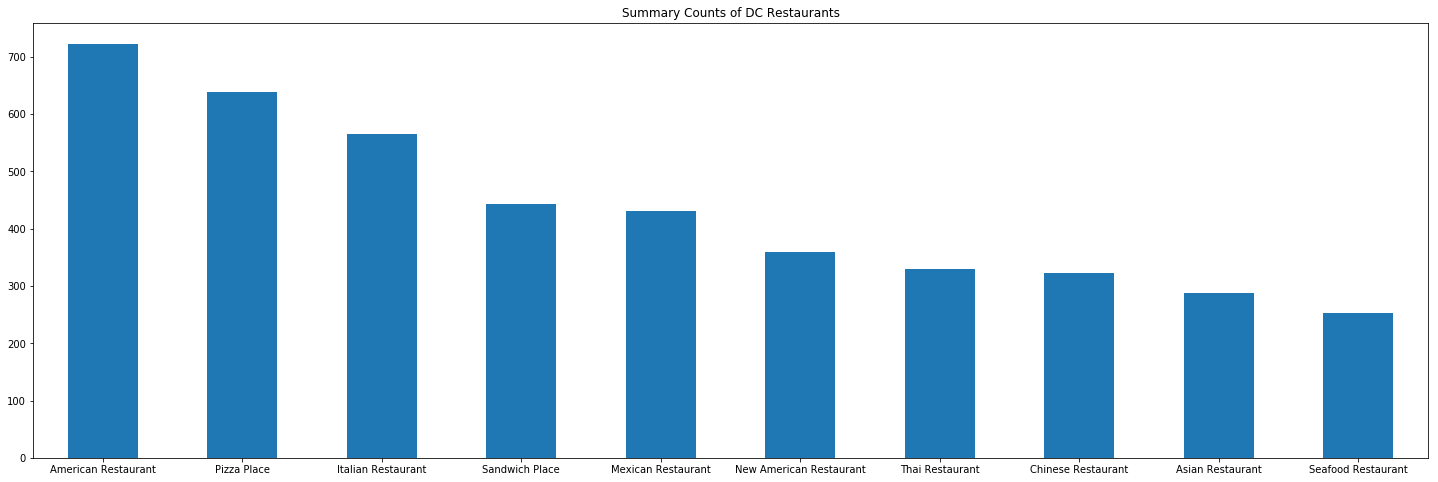

In [14]:
df_Counts = DC_venues['Venue Category'].value_counts()
df_Counts = df_Counts.head(10)
df_Counts
ax = df_Counts.plot.bar(x=1, rot=0, figsize=(25,8), title="Summary Counts of DC Restaurants")

### 3.2 Cluster Analysis

Now that we have ran the algorithm we can examine what the resulting apartment clusters look like.

First I will create a map that plot all the apartments onto a birds eye view of DC. The clusters are broken down bycolor coding to make visualizing more straightforward. 

In [15]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
m=0
for lat, lon, poi, cluster in zip(DC_merged['LATITUDE'], DC_merged['LONGITUDE'], DC_merged['Apartment'], DC_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
    m==m+1
        
map_clusters

As we can see, the largest cluster was cluster 4. The majority of these apartments are located in central DC and my guess is that this resulted in these apartments having the broadest range of food venues. 
The algorithm likely created a "catach all" cluster that these apartments were dumped into. We can take a closer look at some of the apartments within cluster 4 to confirm this assumption. 

In [24]:
# Examine Cluster 4
DC_4 = DC_merged.loc[DC_merged['Cluster Labels'] == 4, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_4.head(15)

Apartment      1st Most Common Venue  \
2747    4827 RUGBY AVENUE, S BETHESDA MD 20814           Indian Restaurant   
2766               PO BOX 4130 OAKTON VA 22124       Vietnamese Restaurant   
2769         P O BOX 11597 WASHINGTON DC 20008         American Restaurant   
2777  6600 SANY SPRING RD  WASHINGTON DC 20012             Thai Restaurant   
2786           3031 SUGAR LANE VIENNA VA 22181         American Restaurant   
2789        730 24TH NW ST WASHINGTON DC 20037         American Restaurant   
2816     717 IRVING ST NE  WASHINGTON DC 20017                  Food Court   
2818  1350 CONNECTICUT AVE WASHINGTON DC 20036    Mediterranean Restaurant   
2821  901 TAYLOR STREET, N WASHINGTON DC 20017   Latin American Restaurant   
2836     2501 PORTER ST NW WASHINGTON DC 20008             Thai Restaurant   
2874         4938 HAMPDEN LN BETHESDA MD 20814          Italian Restaurant   
2904       1116 5TH ST NW  WASHINGTON DC 20001         American Restaurant   
2919            9615 Maury Rd FAIRFAX VA 22032                  Restaurant   
2956  6172 DEER RIDGE TRL SPRINGFIELD VA 22150   Latin American Restaurant   
2980   3460 14TH STREET NW WASHINGTON DC 20010                 Pizza Place   

        2nd Most Common Venue            3rd Most Common Venue  \
2747              Pizza Place              American Restaurant   
2766              Pizza Place               Italian Restaurant   
2769  New American Restaurant    Vegetarian / Vegan Restaurant   
2777     Ethiopian Restaurant  Southern / Soul Food Restaurant   
2786          Thai Restaurant                 Sushi Restaurant   
2789       Italian Restaurant                 Sushi Restaurant   
2816      American Restaurant               Chinese Restaurant   
2818              Pizza Place                  Thai Restaurant   
2821      Xinjiang Restaurant                Food & Drink Shop   
2836       Italian Restaurant         Mediterranean Restaurant   
2874        Indian Restaurant          New American Restaurant   
2904  New American Restaurant               Italian Restaurant   
2919      American Restaurant          New American Restaurant   
2956       Mexican Restaurant               Chinese Restaurant   
2980       Mexican Restaurant        Latin American Restaurant   

                4th Most Common Venue      5th Most Common Venue  \
2747                French Restaurant           Asian Restaurant   
2766               Mexican Restaurant          Indian Restaurant   
2769               Italian Restaurant         Mexican Restaurant   
2777               African Restaurant           Asian Restaurant   
2786               Mexican Restaurant         Italian Restaurant   
2789                Indian Restaurant  South American Restaurant   
2816        Latin American Restaurant          Food & Drink Shop   
2818               Italian Restaurant             Sandwich Place   
2821              Empanada Restaurant         English Restaurant   
2836               Mexican Restaurant        Xinjiang Restaurant   
2874                  Thai Restaurant         Seafood Restaurant   
2904  Southern / Soul Food Restaurant                Pizza Place   
2919        Latin American Restaurant         African Restaurant   
2956        South American Restaurant           Cuban Restaurant   
2980                 Asian Restaurant      Vietnamese Restaurant   

          6th Most Common Venue      7th Most Common Venue  \
2747                 Food Truck             Sandwich Place   
2766          German Restaurant                Salad Place   
2769           Sushi Restaurant         Belgian Restaurant   
2777         Italian Restaurant           Sushi Restaurant   
2786          Indian Restaurant  Latin American Restaurant   
2789         Falafel Restaurant         Mexican Restaurant   
2816         English Restaurant       Ethiopian Restaurant   
2818        Filipino Restaurant        Empanada Restaurant   
2821       Ethiopian Restaurant         Falafel Restaurant   
2836             Sandwi

As we can see the assumption that this cluster is a bit of mixed bag is correct. We can apply this data drilldown to the rest of the clusters as well. 

In [28]:
# Examine Cluster 0
DC_1 = DC_merged.loc[DC_merged['Cluster Labels'] == 0, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_1.head(15)

Apartment 1st Most Common Venue  \
3043     2202 18TH STREET N.W WASHINGTON DC 20009     Chinese Restaurant   
3258     1925 ROSEDALE STREET WASHINGTON DC 20002   Fast Food Restaurant   
3310               P.O. BOX 1576 CLINTON MD 20735         Sandwich Place   
3645     905 BUTTERNUT ST NW  WASHINGTON DC 20012   Fast Food Restaurant   
5079         3299K ST NW #700 WASHINGTON DC 20007      Indian Restaurant   
5144    5301 Wisconsin Ave   Washington  DC 20015      Indian Restaurant   
5298          71 O STREET, NW WASHINGTON DC 20001         Sandwich Place   
5350          1322 MAIN DR NW WASHINGTON DC 20012   Fast Food Restaurant   
5675       115 EAST 13TH STREET NEW YORK NY 10013   Fast Food Restaurant   
5796     6901 4th STREET N.W. WASHINGTON DC 20019   Fast Food Restaurant   
5860     1914 9th STREET N.W. WASHINGTON DC 20001   Fast Food Restaurant   
6109     479 ORANGE STREET S. WASHINGTON DC 20032   Fast Food Restaurant   
6502        PO BOX 30046      WASHINGTON DC 20020         Sandwich Place   
6569              6 CARVER RD CABIN JOHN MD 20818   Fast Food Restaurant   
6626  8455 COLESVILLE ROAD SILVER SPRING MD 20910   Fast Food Restaurant   

                2nd Most Common Venue 3rd Most Common Venue  \
3043             Fast Food Restaurant   Xinjiang Restaurant   
3258              Xinjiang Restaurant     Food & Drink Shop   
3310             Fast Food Restaurant   Xinjiang Restaurant   
3645              Xinjiang Restaurant     Food & Drink Shop   
5079             Fast Food Restaurant     Food & Drink Shop   
5144             Fast Food Restaurant     Food & Drink Shop   
5298             Fast Food Restaurant   Xinjiang Restaurant   
5350              Xinjiang Restaurant     Food & Drink Shop   
5675              Xinjiang Restaurant     Food & Drink Shop   
5796  Southern / Soul Food Restaurant   Xinjiang Restaurant   
5860              Xinjiang Restaurant     Food & Drink Shop   
6109              Xinjiang Restaurant     Food & Drink Shop   
6502             Fast Food Restaurant   Xinjiang Restaurant   
6569              Xinjiang Restaurant     Food & Drink Shop   
6626              Xinjiang Restaurant     Food & Drink Shop   

     4th Most Common Venue        5th Most Common Venue 6th Most Common Venue  \
3043   Dumpling Restaurant          Empanada Restaurant    English Restaurant   
3258   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
3310            Dosa Place  Eastern European Restaurant   Empanada Restaurant   
3645   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
5079   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
5144   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
5298            Dosa Place  Eastern European Restaurant   Empanada Restaurant   
5350   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
5675   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
5796            Dosa Place  Eastern European Restaurant   Empanada Restaurant   
5860   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
6109   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
6502            Dosa Place  Eastern European Restaurant   Empanada Restaurant   
6569   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   
6626   Empanada Restaurant           English Restaurant  Ethiopian Restaurant   

     7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
3043  Ethiopian Restaurant    Falafel Restaurant   Filipino Restaurant   
3258    Falafel Restaurant   Filipino Restaurant                  Food   
3310    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3645    Falafel Restaurant   Filipino Restaurant                  Food   
5079    Falafel Restaurant   Filipino Restaurant                  Food   
5144    Falafel Restaurant   Filipino Restaurant                  Food   


In [29]:
# Examine Cluster 1
DC_1 = DC_merged.loc[DC_merged['Cluster Labels'] == 1, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_1.head(15)

Apartment  \
3077             P.O. BOX 6373 WASHINGTON DC 20015    
3222      1928 Benning Road ne WASHINGTON DC 20002    
3285        5133 CALL PLACE SE WASHINGTON DC 20019    
3293            P.O. BOX 50215 WASHINGTON DC 20001    
3349      2709 12th STREET N.E Washington DC 20018    
3364            5326 BUXTON CT ALEXANDRIA VA 22315    
3462      350 U street NE suit washington DC 20002    
3518          7219 16TH ST NW  WASHINGTON DC 20012    
3933  11601 WILLIAM BEANS  UPPER MARLBORO MD 20772    
4182           309 E STREET NW WASHINGTON DC 20001    
4189        4115 First St.  SE Washington DC 20024    
4346        33 GALVESTON ST SW WASHINGTON DC 20032    
4448             323 Gorman Avenue Laurel MD 20707    
4455           309 E Street NW Washington DC 20001    
4475               c/o Stoladi Washington DC 20009    

              1st Most Common Venue 2nd Most Common Venue  \
3077             Chinese Restaurant    Seafood Restaurant   
3222            American Restaurant    Chinese Restaurant   
3285             Chinese Restaurant   Xinjiang Restaurant   
3293  Vegetarian / Vegan Restaurant    Chinese Restaurant   
3349             Chinese Restaurant           Pizza Place   
3364             Chinese Restaurant           Pizza Place   
3462             Chinese Restaurant   Peruvian Restaurant   
3518             Chinese Restaurant   Xinjiang Restaurant   
3933             Chinese Restaurant                  Food   
4182  Vegetarian / Vegan Restaurant    Chinese Restaurant   
4189             Chinese Restaurant           Pizza Place   
4346             Chinese Restaurant   Xinjiang Restaurant   
4448             Chinese Restaurant                  Food   
4455             Chinese Restaurant   Xinjiang Restaurant   
4475             Chinese Restaurant   Xinjiang Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3077   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
3222   Xinjiang Restaurant     Food & Drink Shop    English Restaurant   
3285   Dumpling Restaurant   Empanada Restaurant    English Restaurant   
3293   Xinjiang Restaurant                  Food   Empanada Restaurant   
3349   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
3364   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
3462   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
3518   Dumpling Restaurant   Empanada Restaurant    English Restaurant   
3933   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
4182   Xinjiang Restaurant                  Food   Empanada Restaurant   
4189   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
4346   Dumpling Restaurant   Empanada Restaurant    English Restaurant   
4448   Xinjiang Restaurant   Dumpling Restaurant   Empanada Restaurant   
4455   Dumpling Restaurant   Empanada Restaurant    English Restaurant   
4475   Dumpling Restaurant   Empanada Restaurant    English Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3077    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3222  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
3285  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
3293    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3349    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3364    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3462    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3518  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
3933    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4182    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4189    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4346  Ethiopian Restaurant    Falafel Restaurant  Fast Food Restaurant   
4448    English Restaurant  Ethiopian

In [30]:
# Examine Cluster 2
DC_1 = DC_merged.loc[DC_merged['Cluster Labels'] == 2, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_1.head(15)

Apartment 1st Most Common Venue  \
2954  3846 CARPENTER ST SE WASHINGTON DC 20020             Restaurant   
2973  C/O WM. CALOMIRIS CO WASHINGTON DC 20036     Chinese Restaurant   
3021     3449 SHAKERTOWN ROAD ANTIOCH TN 37013     Chinese Restaurant   
3055       5113 2ND ST NW  WASHINGTON DC 20011   Caribbean Restaurant   
3059  5805 14th STREET N.W WASHINGTON DC 20011     Chinese Restaurant   
3075   2460 Tunlaw Road NW Washington DC 20007             Restaurant   
3104      1425 H Street NE Washington DC 20002    American Restaurant   
3221  c/o The Community Bu Washington DC 20001            Pizza Place   
3244           116 T ST NE WASHINGTON DC 20002   Caribbean Restaurant   
3397  812 CHESAPEAKE STREE WASHINGTON DC 20032                   Food   
3416  1433 T St. NW apt.#T WASHINGTON DC 20009            Pizza Place   
3426          1226 F St NE Washington DC 20002            Pizza Place   
3429   15204 BUNCHBERRY COU N POTOMAC MD 20878             Restaurant   
3498      2208 RUSSELLL RD ALEXANDRIA VA 22301     Chinese Restaurant   
3500  2911 GEORGIA AVENUE  WASHINGTON DC 20001            Pizza Place   

                2nd Most Common Venue        3rd Most Common Venue  \
2954                   Sandwich Place                  Pizza Place   
2973        Latin American Restaurant                   Taco Place   
3021                  Thai Restaurant                  Pizza Place   
3055               Persian Restaurant          Xinjiang Restaurant   
3059                       Restaurant                   Taco Place   
3075                             Food  Eastern European Restaurant   
3104                      Pizza Place               Sandwich Place   
3221  Southern / Soul Food Restaurant           Mexican Restaurant   
3244              Xinjiang Restaurant          Dumpling Restaurant   
3397                 Asian Restaurant           Seafood Restaurant   
3416  Southern / Soul Food Restaurant          American Restaurant   
3426             Fast Food Restaurant             Asian Restaurant   
3429                   Sandwich Place                  Pizza Place   
3498        Latin American Restaurant                   Restaurant   
3500              Xinjiang Restaurant                         Food   

          4th Most Common Venue 5th Most Common Venue  \
2954       Fast Food Restaurant   Xinjiang Restaurant   
2973        Xinjiang Restaurant                  Food   
3021         Seafood Restaurant   Xinjiang Restaurant   
3055        Dumpling Restaurant   Empanada Restaurant   
3059  Latin American Restaurant            Soup Place   
3075        Empanada Restaurant    English Restaurant   
3104         Chinese Restaurant  Fast Food Restaurant   
3221        American Restaurant    Chinese Restaurant   
3244        Empanada Restaurant    English Restaurant   
3397        Xinjiang Restaurant   Empanada Restaurant   
3416        Xinjiang Restaurant   Empanada Restaurant   
3426           Sushi Restaurant  Pakistani Restaurant   
3429       Fast Food Restaurant   Xinjiang Restaurant   
3498                Pizza Place            Taco Place   
3500        Empanada Restaurant    English Restaurant   

            6th Most Common Venue        7th Most Common Venue  \
2954  Eastern European Restaurant          Empanada Restaurant   
2973          Empanada Restaurant           English Restaurant   
3021          Filipino Restaurant          Empanada Restaurant   
3055           English Restaurant         Ethiopian Restaurant   
3059          Filipino Restaurant  Eastern European Restaurant   
3075         Ethiopian Restaurant           Falafel Restaurant   
3104          Xinjiang Restaurant                         Food   
3221               Sandwich Place           English Restaurant   
3244         Ethiopian Restaurant           Falafel Restaurant   
3397           English Restaurant         Ethiopian Restaurant   
3416           English Restaurant         Ethiopian Restaurant   
3426      New American Restaurant         C

In [31]:
# Examine Cluster 3
DC_1 = DC_merged.loc[DC_merged['Cluster Labels'] == 3, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_1.head(15)

Apartment 1st Most Common Venue  \
2961                 PO BOX 3920 OAKTON VA 22124         Sandwich Place   
3102           2129 Robin Way Ct Vienna VA 22182         Sandwich Place   
3134         6404 BRIGHT PLUME COLUMBIA MD 21044         Sandwich Place   
3238        1447 - G1 DOLLEY MAD MCLEAN VA 22101         Sandwich Place   
3718     5706 FREDERICK AVENU ROCKVILLE MD 20852         Sandwich Place   
4114          57 O Street NW Washington DC 20001         Sandwich Place   
4220    100 SEATON PLACE N.W Washington DC 20001         Sandwich Place   
4432         4922 FAIRMONT AVE BETHESDA MD 20814         Sandwich Place   
4738  606 GREENWICH STREET FALLS CHURCH VA 22046         Sandwich Place   
4757            3308 R ST NW WASHINGTON DC 20007         Sandwich Place   
4844            PO BOX 417      MARBURY MD 20658         Sandwich Place   
5278            PO BOX 50215 WASHINGTON DC 20091         Sandwich Place   
5378       824 KENNEDY ST NE WASHINGTON DC 20011         Sandwich Place   
5600          2300 WISCONSIN AVENU WASHINGTON DC         Sandwich Place   
5699    1005 NORTH CAPITOL S WASHINGTON DC 20002         Sandwich Place   

        2nd Most Common Venue     3rd Most Common Venue  \
2961      Xinjiang Restaurant                Dosa Place   
3102      Xinjiang Restaurant                Dosa Place   
3134      Xinjiang Restaurant                Dosa Place   
3238      Xinjiang Restaurant                Dosa Place   
3718      Xinjiang Restaurant                Dosa Place   
4114  New American Restaurant       Xinjiang Restaurant   
4220      Xinjiang Restaurant                Dosa Place   
4432        Indian Restaurant          Sushi Restaurant   
4738      Xinjiang Restaurant                Dosa Place   
4757      Xinjiang Restaurant                Dosa Place   
4844      Xinjiang Restaurant                Dosa Place   
5278      Xinjiang Restaurant                Dosa Place   
5378      Xinjiang Restaurant                Dosa Place   
5600         Asian Restaurant       Xinjiang Restaurant   
5699      Peruvian Restaurant  Mediterranean Restaurant   

            4th Most Common Venue        5th Most Common Venue  \
2961  Eastern European Restaurant          Empanada Restaurant   
3102  Eastern European Restaurant          Empanada Restaurant   
3134  Eastern European Restaurant          Empanada Restaurant   
3238  Eastern European Restaurant          Empanada Restaurant   
3718  Eastern European Restaurant          Empanada Restaurant   
4114          Dumpling Restaurant          Empanada Restaurant   
4220  Eastern European Restaurant          Empanada Restaurant   
4432                         Food  Eastern European Restaurant   
4738  Eastern European Restaurant          Empanada Restaurant   
4757  Eastern European Restaurant          Empanada Restaurant   
4844  Eastern European Restaurant          Empanada Restaurant   
5278  Eastern European Restaurant          Empanada Restaurant   
5378  Eastern European Restaurant          Empanada Restaurant   
5600                         Food          Empanada Restaurant   
5699          Xinjiang Restaurant          Filipino Restaurant   

     6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
2961    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3102    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3134    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3238    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3718    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4114    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4220    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4432   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
4738    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4757    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4844    English Restaur

In [32]:
# Examine Cluster 5
DC_1 = DC_merged.loc[DC_merged['Cluster Labels'] == 5, DC_merged.columns[[0] + list(range(6, DC_merged.shape[1]))]]
DC_1.head(15)

Apartment 1st Most Common Venue  \
3297     1717 TRINIDAD AVENUE WASHINGTON DC 20002    American Restaurant   
3315         900 MONGOMERY STREET LAUREL MD 20707    American Restaurant   
3337     3711 CUMBERLAND STRE WASHINGTON DC 20016    American Restaurant   
3528         642 Hobart PL NW Washington DC 20001    American Restaurant   
3606              721 K ST NE WASHINGTON DC 20002    American Restaurant   
3780     1629 HOBART STREET N WASHINGTON DC 20009    American Restaurant   
3790         1438 CEDAR ST SE WASHINGTON DC 20020    American Restaurant   
4082  13505 FENDALL CT    UPPER MARLBORO MD 20772    American Restaurant   
4112     1709 Trinidad Avenue Washington DC 20002    American Restaurant   
4140     1317 IRVING STREET N WASHINGTON DC 20010    American Restaurant   
4244           22 WOODLAND WAY GREENBELT MD 20770    American Restaurant   
4296    721 ELLSWORTH AVENUE GREAT FALLS VA 22066    American Restaurant   
4442           3300 6TH ST SE WASHINGTON DC 20032    American Restaurant   
4571             PO BOX 96763 WASHINGTON DC 20090    American Restaurant   
4748     1311 MONTELLO AVE NE WASHINGTON DC 20002    American Restaurant   

        2nd Most Common Venue 3rd Most Common Venue    4th Most Common Venue  \
3297           Sandwich Place   Xinjiang Restaurant                     Food   
3315     Fast Food Restaurant   Xinjiang Restaurant        Food & Drink Shop   
3337           Sandwich Place   Xinjiang Restaurant                     Food   
3528      Xinjiang Restaurant     Food & Drink Shop      Empanada Restaurant   
3606      Xinjiang Restaurant     Food & Drink Shop      Empanada Restaurant   
3780           Sandwich Place    Seafood Restaurant      Xinjiang Restaurant   
3790           Sandwich Place   Xinjiang Restaurant                     Food   
4082           Sandwich Place           Pizza Place  New American Restaurant   
4112           Sandwich Place   Xinjiang Restaurant                     Food   
4140  Comfort Food Restaurant        Sandwich Place     Fast Food Restaurant   
4244           Sandwich Place   Xinjiang Restaurant                     Food   
4296           Sandwich Place   Xinjiang Restaurant                     Food   
4442      Xinjiang Restaurant     Food & Drink Shop      Empanada Restaurant   
4571           Sandwich Place  Fast Food Restaurant      Xinjiang Restaurant   
4748           Sandwich Place   Xinjiang Restaurant                     Food   

     5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3297   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
3315   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
3337   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
3528    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3606    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
3780                  Food   Empanada Restaurant    English Restaurant   
3790   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
4082   Xinjiang Restaurant   Filipino Restaurant   Empanada Restaurant   
4112   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
4140   Xinjiang Restaurant                  Food   Empanada Restaurant   
4244   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
4296   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   
4442    English Restaurant  Ethiopian Restaurant    Falafel Restaurant   
4571                  Food   Empanada Restaurant    English Restaurant   
4748   Empanada Restaurant    English Restaurant  Ethiopian Restaurant   

     8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
3297    Falafel Restaurant  Fast Food Restaurant    Filipino Restaurant  
3315    Falafel Restaurant   Filipino Restaurant                   Food  
3337    Falafel Restaurant  Fast Food Restaurant    Filipino Restaurant  
3528  Fast Food Restaurant   Filipino Restaurant              

## 4.0 Discusion

### 4.1 Key Points

My results have some key takeaways. 

1. DC has a large volume of restaurants to choose from that encompass a variety of dining options. A summary of the most common venues for every apartment can be found below:
    - American Restaurants - apx. 700
    - Pizza Place - apx. 650
    - Italian Restaurant - apx. 600
2. Clustering provided us with good insights into what types of apartments could exist in terms of dining options. Someone looking for an apartment could use the following summary to help their decision:
    - Cluster 0 (West & SW DC) - Fast food and various Asian cuisines options
    - Cluster 1 (Central & West DC) - Chinese and Dumpling restaurants
    - Cluster 2 (Central & North DC) - Good variety with some preference towards Asian Cuisine
    - Cluster 3 (Central & West DC) - People who really like sandwich places and Chinese Food
    - Cluster 4 (Central DC) - Widest variety of options. Something for everyone
    - Cluster 5 (Central & South DC) - People who love American Restaurants and Sandwiches
    
We can look at a real example to see how someone would actually use a project like this. 

I have chosen a random Apartment out of CLuster 4 and have looked into the rent and available units. 

The Apartment I chose is right in the middle of Dupont Circle and we can see via Google maps that it does in fact have the dining options that my research found. The company that manages the property can be found [here](https://www.pngs.com/) and we can see there are listings available

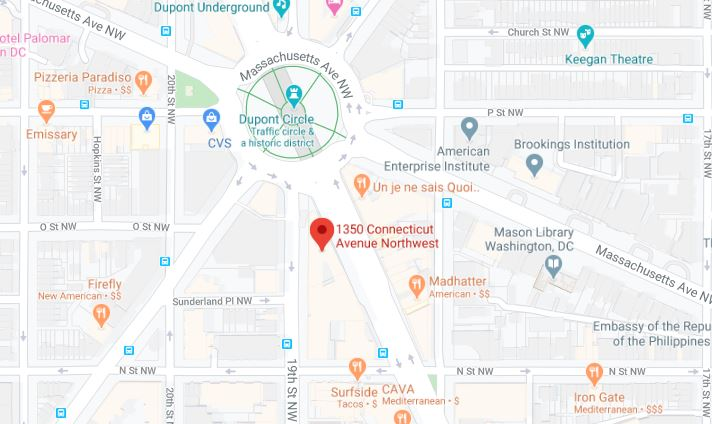

### 4.2 Evaluating

I think the key pieces of this project to evaluate would be the use of K Means Clustering as my algorithm choice, as well as the reality of using only food venues to make a choice for the a arangement.

#### Point 1:

While there are certainly other clustering methods available, I wanted to use K Means becasue it is fast and works just fine for working with geographic data. If I wanted to repeat this experiment with even more data, for instance, multiple cities worth, I could still see reasonable calculation speeds by sticking with K Means. In this sense it is quite scalable. The biggest downside I see with my use of the algorithm is the fact that I may not have gotten the most optimized number of clusters. Other algorithms such as DBSCAN arguably allow for greater assenment of spacial data. In this instance though I think my results along with the scalability of my project justify the use of K Means

#### Point 2:

In terms of this projects real world functionality I obviously recognize that food options are not the only thing to drive someones housing decision. For the sake of this project acting as a proof of concept I think using restaurants as a variable for clustering is completely acceptable and also keeps things fun and relateble foreveryone.

## 5.0 Conclusion

Overall this project accomplished its goal. The problem was meant to be rather light hearted while at the same time showcasing what machine learning methods are capable of from an analysis stand point. Who know, maybe a true foodie out there could actually love cusine enough to base their entire living situation around it. 

I hope you enjoyed this project and found it educational.

Best,

Kai Hannum